In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate


2023-11-20 15:03:16.873843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:

# Load data and masks
data_dir = 'dataset2'  # Replace with your directory path
case_folders = sorted(os.listdir(data_dir))
images = []
masks = []


for folder in case_folders:
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip if it's not a directory
        
    image_files = sorted(os.listdir(folder_path))
    for img_name in image_files:
        if img_name.endswith('.tif') and not img_name.endswith('_mask.tif'):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            images.append(img)
            
        if img_name.endswith('_mask.tif'):
            mask_path = os.path.join(folder_path, img_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            masks.append(mask)

images = np.array(images)
masks = np.array(masks)

# Preprocess data
# Normalize images
images = images / 255.0
# Reshape masks to add channel dimension
masks = np.expand_dims(masks, axis=-1)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [5]:
X_train = X_train[:100]
X_val = X_val[:50] 
y_train = y_train[:100]
y_val = y_val[:50]


In [6]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = conv4
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), drop4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9) 

    model = Model(inputs=[inputs], outputs=[outputs])
    return model



In [7]:

input_shape = images.shape[1:]
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(lr= 0.1), loss='binary_crossentropy', metrics=['accuracy'])


/Users/ishantkamboj/anaconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=2, verbose=1)


Epoch 1/2
4/4 [==============================] - 437s 107s/step - loss: nan - accuracy: 0.0505 - val_loss: nan - val_accuracy: 0.9836
Epoch 2/2
4/4 [==============================] - 346s 83s/step - loss: nan - accuracy: 0.9888 - val_loss: nan - val_accuracy: 0.9836


In [10]:

model.save("model10.h5")
# Load the model
# model = load_model('model2.h5')

# Evaluation
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')



In [11]:

# Prediction
predicted_masks = model.predict(X_val[:10])

1/1 [==============================] - 7s 7s/step


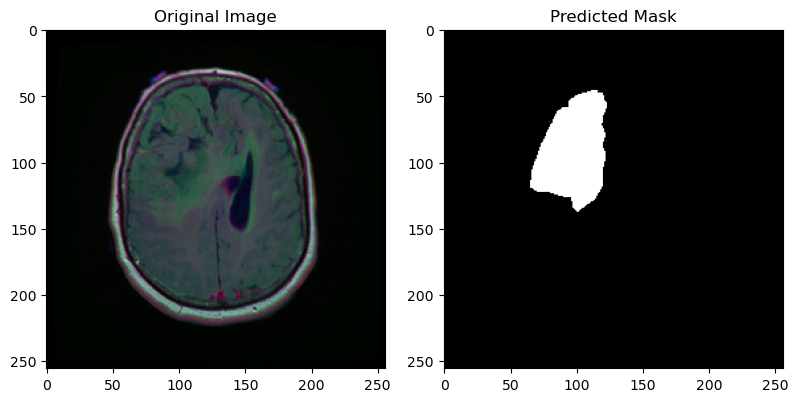

In [17]:

# Visualization
# predicted_mask = predicted_masks[1]
def visualize_segmentation(image, mask, predicted_mask):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    
    plt.tight_layout()
    plt.show()

# Visualize a sample
sample_index = 5  # Change this index to visualize different samples
visualize_segmentation(X_val[sample_index], y_val[sample_index].squeeze(), predicted_masks[sample_index].squeeze())
